In [1]:
from qa_qc_lib.qa_qc_kern import QA_QC_kern
import numpy as np


In [2]:
x=np.array([3,4,5])
y=np.array([1,2,3])
arr=np.array([1,1,1])
path=r"C:\Users\nikit\OneDrive\Рабочий стол\Test"
tests = QA_QC_kern(first_array_for_dependency_testing=x,second_array_for_dependency_testing=y,array_for_first_order_tests=arr,file_path=path)

In [3]:
list_of_tests = tests.get_list_of_tests()

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


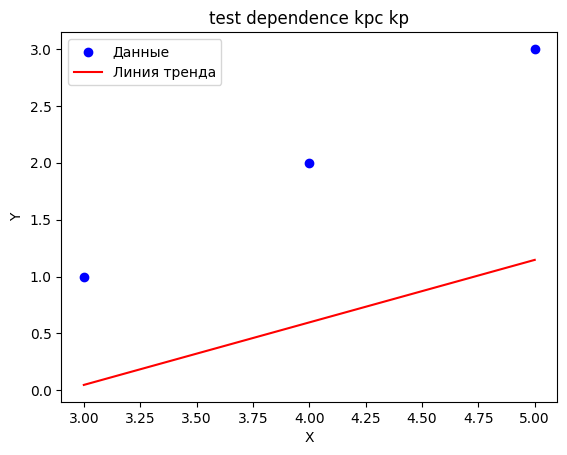

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


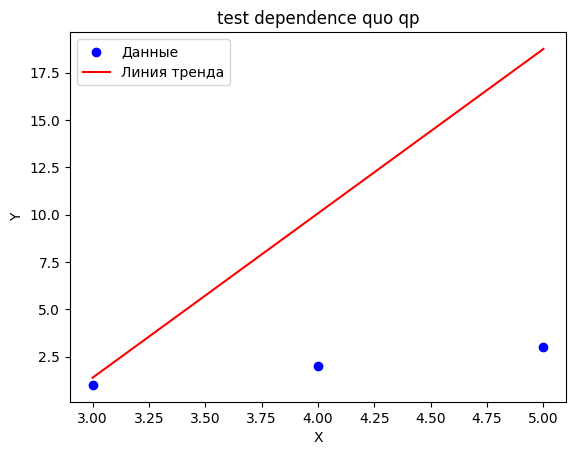

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


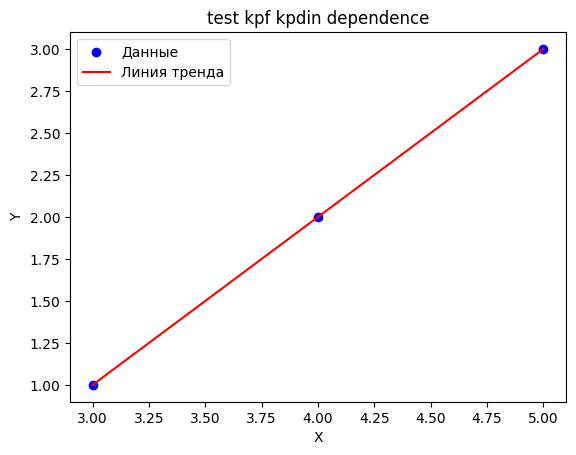

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


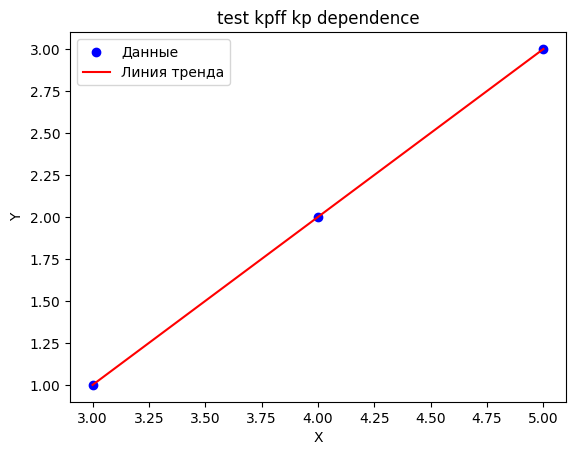

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


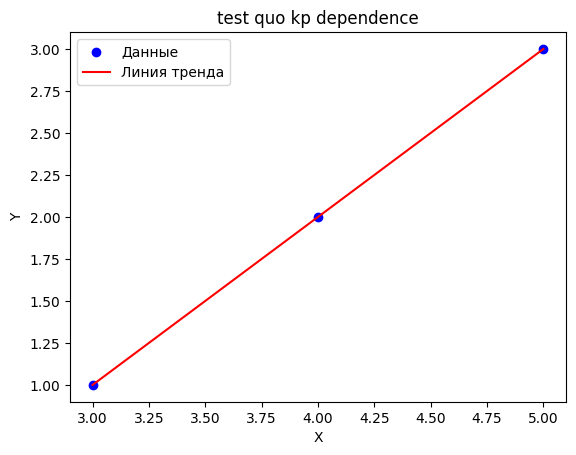

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


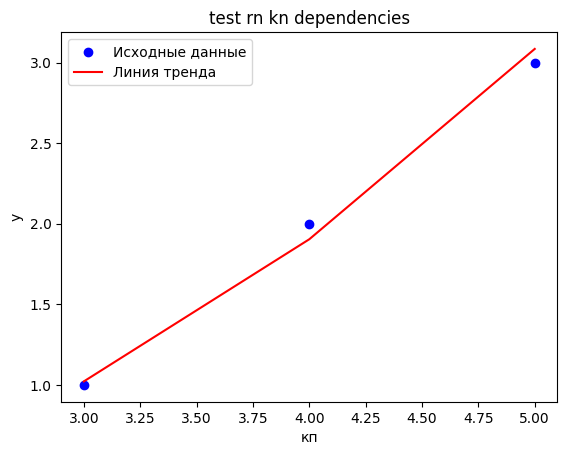

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


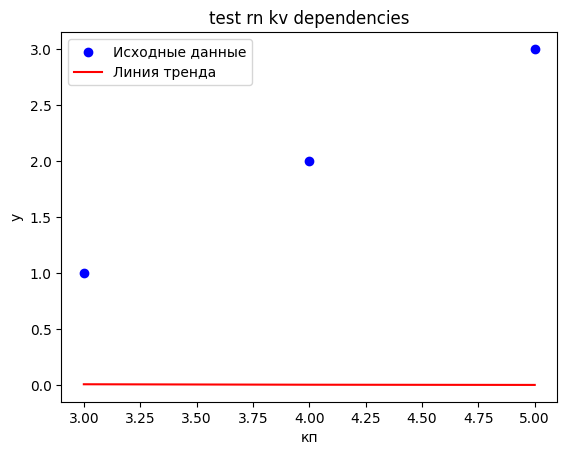

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


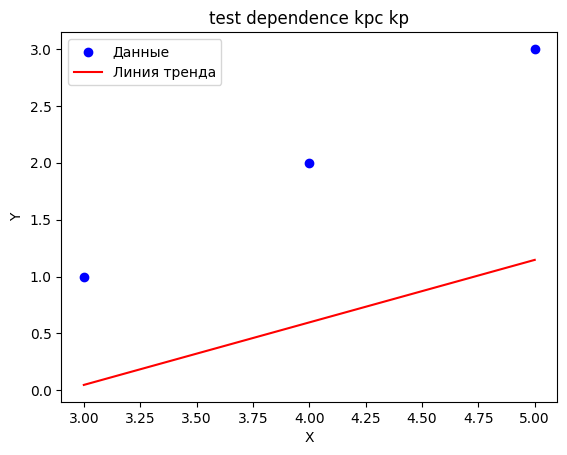

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


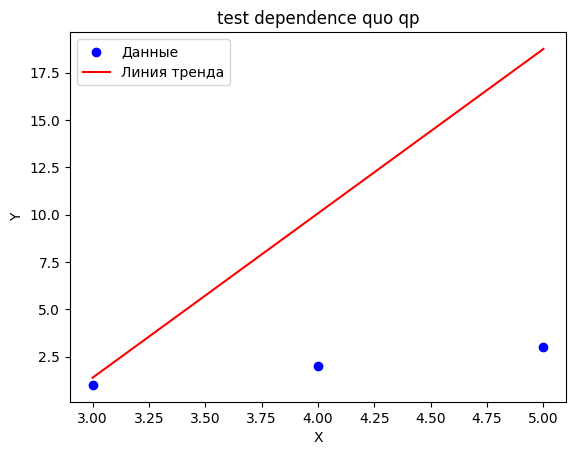

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


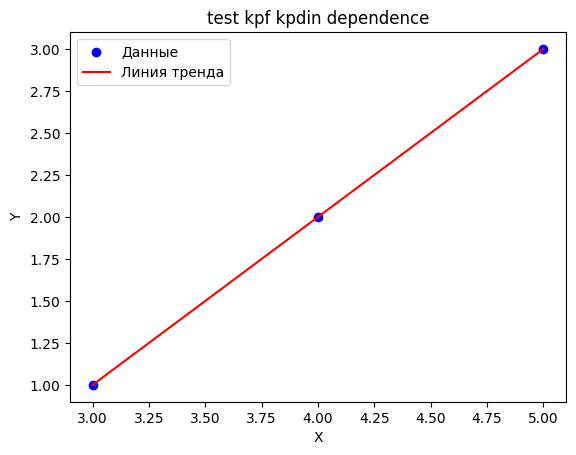

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


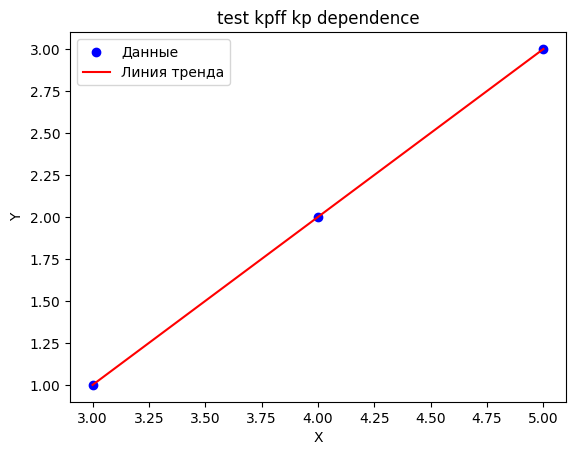

In [4]:
tests.start_tests(list_of_tests)
tests.start_tests(list_of_tests[0:13])

In [5]:
tests.generate_test_report()

'C:\\Users\\nikit\\OneDrive\\Рабочий стол\\Test\\test_report.txt'